# Image Classification with Keras
## (Custom Model vs Transfer Learning using VGG16)

Members: Group 6

Devanshi Pankaj Wadkar – 22065576

Sandra Binu – 22029960

Sohan Kumar Narayanaswamy – 22085239

Nikhil Dinesh Soni – 22045846

Melvin Sebastian - 22083837

Hridhya Joy - 22074909



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required Libraries

In [ ]:
# Importing the Core TensorFlow library for machine learning and deep learning.
import tensorflow as tf
# Utilities for image data manipulation and decoding predictions.
from tensorflow.keras.preprocessing import image
# Importing os module for operating system interactions, such as file path management.
import os
# Importing the Python Imaging Library(PIL) for image processing tasks.
import PIL
# Importing components from TensorFlow's Keras for building and training neural networks.
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
# Importing modules Dense, Dropout, and Flatten layers for constructing neural network layers.
from keras.layers import Dense, Dropout, Flatten
# Importing Conv2D and MaxPooling2D layers for building convolutional neural networks.
from keras.layers import Conv2D, MaxPooling2D
# Utility to visualizing the architecture of neural networks.
from keras.utils import plot_model
# Matplotlib for plotting
import matplotlib.pyplot as plt
# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np
# to_categorical function from TensorFlow's Keras utilities for converting class vector to binary class matrix.
from tensorflow.keras.utils import to_categorical
import zipfile
# pandas dataframe for accessing the Series
import pandas as pd
# Importing VGG16 pre-trained model from TensorFlow's Keras applications module
from tensorflow.keras.applications import VGG16
# library for visualising the models
import visualkeras

ModuleNotFoundError: No module named 'visualkeras'

In [ ]:
# Import the drive module from the google.colab package.
from google.colab import drive
# Mounts the Google Drive to the specified mount point in the Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


### Extract and Load the Dataset

In [ ]:
# Extracting files from the specified zip archive.
# Opens the zip file in read mode
zip_data = zipfile.ZipFile(r'/content/drive/MyDrive/Archive (3).zip')
zip_data.extractall('/tmp') #Extracts the files into the /tmp folder
zip_data.close()

NameError: name 'zipfile' is not defined

In [ ]:
# Assuming you have already uploaded and extracted the Intel Image Classification dataset
# Directory paths for training, validation, and prediction datasets.train_data_dir = '/tmp/seg_train/seg_train'
validation_data_dir = '/tmp/seg_test/seg_test'
pred_data_dir = '/tmp/seg_pred/seg_pred'

### Load and Preprocess the data

In [ ]:
# Function to load and preprocess data from train and test directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category  # Use the folder name as the label for all images in this folder
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow

In [ ]:
# Function to load and preprocess data from prediction directory
def load_and_preprocess_prediction_data(directory, image_size):
    data = []  # Initialize a list to store image data
    filenames = []  # Initialize a list to store image filenames
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)  # Get the full path to the image
        # Load and preprocess the image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        # Convert the image to a numpy array
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        image_array = image_array / 255.0  # Normalize the image data to 0-1 range
        data.append(image_array)  # Append the processed image data to the data list
          # Append the filename to the filenames list
    return np.array(data)  # Convert the list of images to a numpy array and return along with filenames

In [ ]:
# Define image size for the model
image_size = (128,128)

# Loading and preprocessing Training and Validation data.
train_images, train_labels = load_and_preprocess_data(train_data_dir, image_size)
test_images, test_labels = load_and_preprocess_data(validation_data_dir, image_size)
# Loading and preprocessing prediction images.
prediction_images = load_and_preprocess_prediction_data(pred_data_dir, image_size)

### EDA on the image dataset

In [ ]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (14034, 128, 128, 3)
Labels shape: (14034,)


In [ ]:
# Print the shape of the data and labels arrays
print("Data shape:", test_images.shape)
print("Labels shape:", test_labels.shape)

Data shape: (3000, 128, 128, 3)
Labels shape: (3000,)


In [ ]:
# Distribution of Data points among classes
freq = pd.Series(train_labels).value_counts()
print(freq)

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: count, dtype: int64


In [ ]:
# obtaining unique class labels from the training labels and assigning to class_names.
class_names = np.unique(train_labels)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
# `num_classes` will hold the total number of classes.
num_classes = len(class_names)
num_classes

6

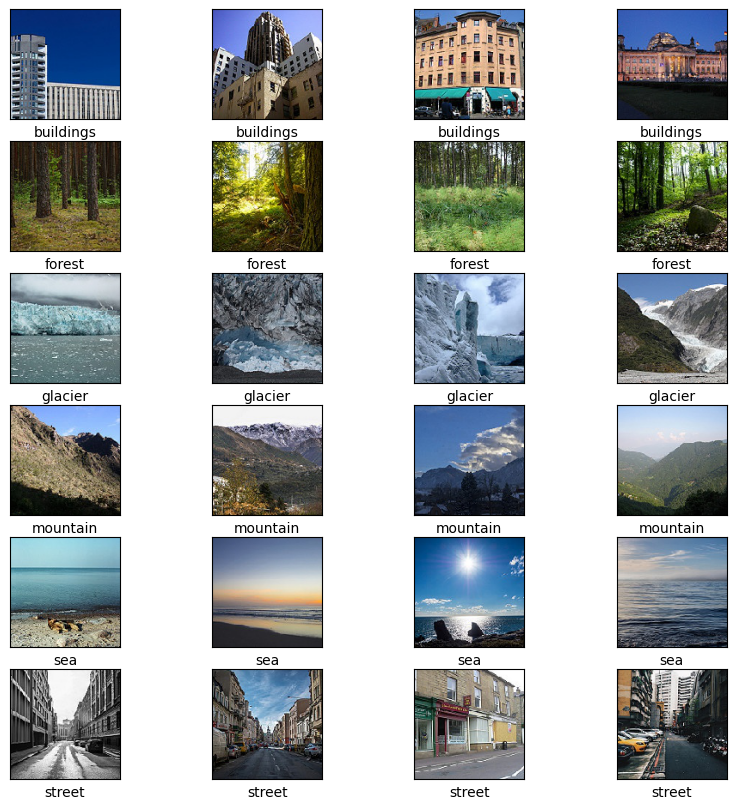

In [ ]:
#Create dictionaries for mapping between class labels and their indices,
# and between indices and their corresponding class labels
label_to_index = {label: index for index, label in enumerate(class_names)}
index_to_label = {index: label for label, index in label_to_index.items()}

# Initialize a list to store the indices of images from each class
class_indices = [[] for _ in range(6)]

# Group the indices of images by class
for i, label in enumerate(train_labels):
    class_index = label_to_index[label]  # Convert label to index
    class_indices[class_index].append(i)

# Select 4 random images from each class
random_indices = []
for indices in class_indices:
    random_indices.extend(np.random.choice(indices, size=4, replace=False))

# Plot the selected images
plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(6, 4, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])
    label_index = label_to_index[train_labels[random_index]]
    plt.xlabel(class_names[label_index])
plt.show()

#### Encode the class labels

In [ ]:
# Creating a dictionaries for mapping
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

# Encode labels using class indices
train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

# Converting encoded labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=6)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=6)

### Building Custom CNN Model and Training

In [ ]:
# Define the CNN model
cnn_model = Sequential()
num_classes = len(class_names)

# Define Convolutional layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Define Flatten layer
cnn_model.add(Flatten())

# Define Fully connected layers
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))  # 6 categories, hence 6 output neurons with softmax activation

In [ ]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,549,702 (24.99 MB)

 Trainable params: 6,549,702 (24.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model on the training data and validate it using the test data
cnn_history = cnn_model.fit(train_images, train_labels_one_hot , epochs=10,
                    validation_data=(test_images, test_labels_one_hot),batch_size=128)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.4590 - loss: 1.3357 - val_accuracy: 0.6840 - val_loss: 0.8296
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 569ms/step - accuracy: 0.6857 - loss: 0.8097 - val_accuracy: 0.7693 - val_loss: 0.6611
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 717ms/step - accuracy: 0.7999 - loss: 0.5557 - val_accuracy: 0.7737 - val_loss: 0.6328
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 842ms/step - accuracy: 0.8237 - loss: 0.4829 - val_accuracy: 0.7903 - val_loss: 0.5826
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 89s 809ms/step - accuracy: 0.8627 - loss: 0.3812 - val_accuracy: 0.8220 - val_loss: 0.5172
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 721ms/step - accuracy: 0.8976 - loss: 0.2929 - val_accuracy: 0.8230 - val_loss: 0.5453
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 96s 874ms/step - accuracy: 0.9264 - loss: 0.2218 - val_accuracy: 0.8337 - val_loss: 0.5750
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 719ms/step - accuracy: 0.9542 - loss: 0.1

#### Evaluate the custom Model

Validation loss average:  0.6492967188358307
Training loss average:  0.41425618901848793


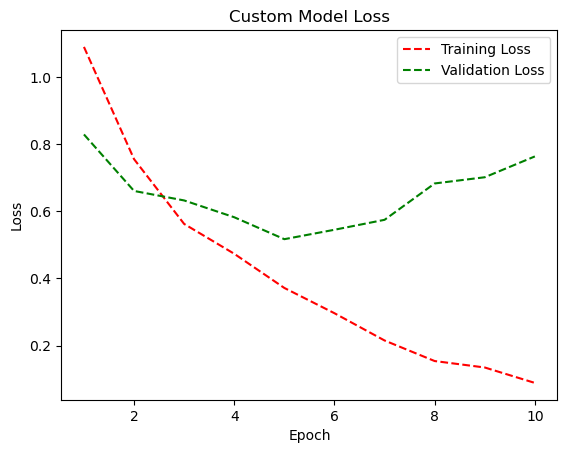

In [ ]:
#CNN Custom model loss plot
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epoch = range(1, len(loss) + 1)
plt.plot(epoch, loss, 'r--')
plt.plot(epoch, val_loss, 'g--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss','Validation Loss'])
plt.title("Custom Model Loss")
plt.savefig('cnn_model_loss.png')

# Calculate and print the average validation loss.
print("Validation loss average: ", np.mean(val_loss))
# Calculate and print the average training loss.
print("Training loss average: ", np.mean(loss))

Validation accuracy average:  0.7933000087738037
Training accuracy average:  0.8470642685890197


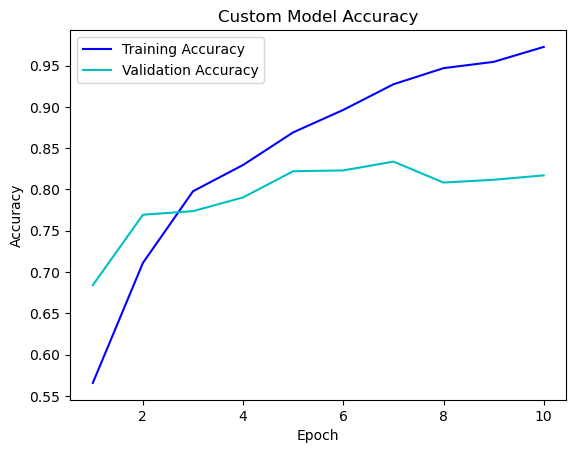

In [ ]:
#CNN Custom model accuracy plot
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
epoch = range(1, len(loss) + 1)
plt.plot(epoch, acc, 'b-')
plt.plot(epoch, val_acc, 'c-')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title("Custom Model Accuracy")
plt.savefig('cnn_model_acc.png')

# Calculate and print the average validation accuracy.
print("Validation accuracy average: ", np.mean(val_acc))
# Calculate and print the average vtraining accuracy.
print("Training accuracy average: ", np.mean(acc))

#### Predict the image classes using the scratch custom model

In [ ]:
# First, get predictions for validation images
predicted_scores_cnn = cnn_model.predict(prediction_images)
predicted_labels_cnn = np.argmax(predicted_scores_cnn, axis=1)

random_indices = np.random.choice(len(prediction_images), size=10, replace=False)
print(len(prediction_images))

# Plot the prediction images along with their predicted labels
plt.figure(figsize=(15, 15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(10, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prediction_images[random_index])
    predicted_label_cnn = index_to_label[predicted_labels_cnn[random_index]]
    plt.xlabel(f"{predicted_label_cnn}")  # Plotting predicted label (true label)

# Save the plot as an image file
# plt.savefig("prediction_plot_cnn_model.png")
plt.show()

### Transfer Learning using VGG16 Model

In [ ]:
#Load the VGG16 model pre-trained on ImageNet, excluding the fully connected layers (include_top=False),
# using 128x128 RGB images as input shape, and initializing the model weights with ImageNet weights.
vgg_model = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(128,128,3))

58889256/58889256 [==============================] - 0s 0us/step


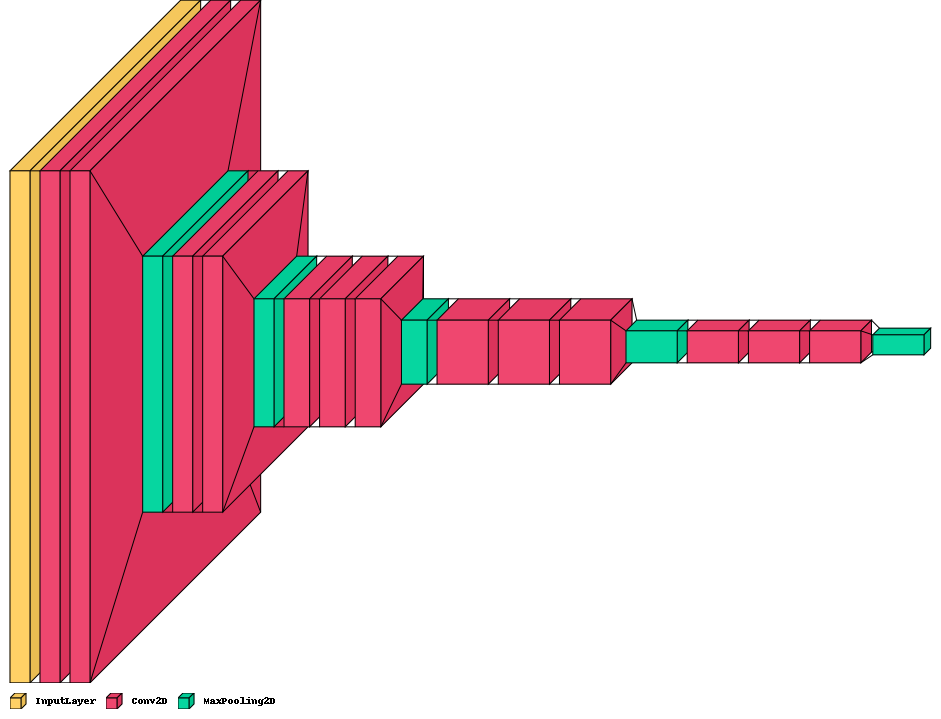

In [ ]:
# visualize the model
visualkeras.layered_view(vgg_model,legend=True)

#### Finetune the model

In [ ]:
#Set all layers in the VGG16 model to be non-trainable (frozen)
for layer in vgg_model.layers:
      layer.trainable = False

In [ ]:
# Summary of the vgg16 model
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Initialize a Sequential model.
model = models.Sequential()
# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
model.add(vgg_model)
# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) # Add a Dense (fully connected) layer to interpret the features extracted by VGG16.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
model.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,011,540 (80.15 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,197,902 (16.01 MB)

In [ ]:
# Train the Transfer learning model
history = model.fit(train_images, train_labels_encoded , epochs=10,
                    validation_data=(test_images, test_labels_encoded),batch_size=128)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 821s 7s/step - accuracy: 0.6707 - loss: 0.9875 - val_accuracy: 0.8687 - val_loss: 0.3664
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 827s 8s/step - accuracy: 0.8642 - loss: 0.3781 - val_accuracy: 0.8633 - val_loss: 0.3538
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 831s 8s/step - accuracy: 0.8799 - loss: 0.3269 - val_accuracy: 0.8877 - val_loss: 0.3200
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 859s 8s/step - accuracy: 0.8936 - loss: 0.2934 - val_accuracy: 0.8883 - val_loss: 0.3136
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 863s 8s/step - accuracy: 0.9022 - loss: 0.2710 - val_accuracy: 0.8873 - val_loss: 0.3079
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 855s 8s/step - accuracy: 0.9102 - loss: 0.2455 - val_accuracy: 0.8803 - val_loss: 0.3123
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 841s 8s/step - accuracy: 0.9136 - loss: 0.2316 - val_accuracy: 0.8913 - val_loss: 0.3097
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 838s 8s/step - accuracy: 0.9214 - loss: 0.2067 - val_accu

#### Evaluate the vgg16 model

Validation loss average:  0.32306727170944216


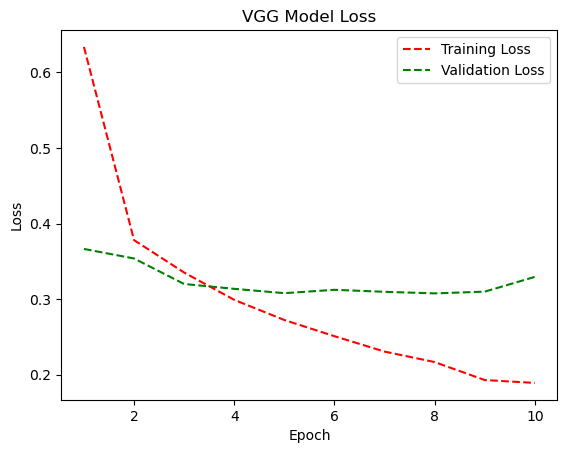

In [ ]:
#VGG16 model loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)

# Plot training and validation loss
plt.plot(epoch, loss, 'r--')
plt.plot(epoch, val_loss, 'g--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss','Validation Loss'])
plt.title("VGG Model Loss")
plt.savefig('vgg_model_loss.png')

# Calculate and print the average validation loss.
print("Validation loss average: ", np.mean(val_loss))

Validation accuracy average:  0.8831666588783265


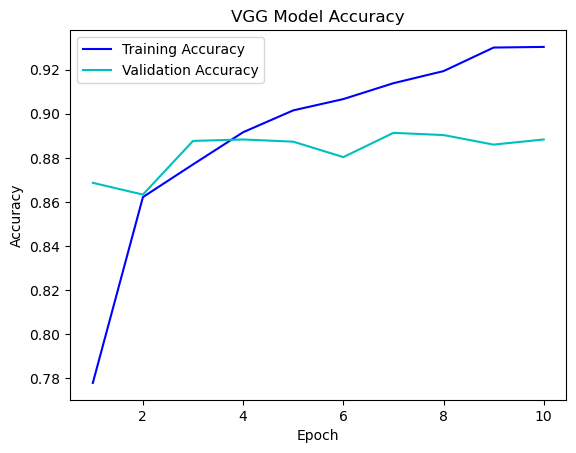

In [ ]:
#VGG16 model accuracy plot
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.plot(epoch, acc, 'b-')
plt.plot(epoch, val_acc, 'c-')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title("VGG Model Accuracy")
plt.savefig('vgg_model_acc.png')

# Calculate and print the average Training accuracy.
print("Training accuracy average: ", np.mean(acc))
# Calculate and print the average validation accuracy.
print("Validation accuracy average: ", np.mean(val_acc))

#### Predicting the Image classes with transfer learning model

229/229 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step
7301


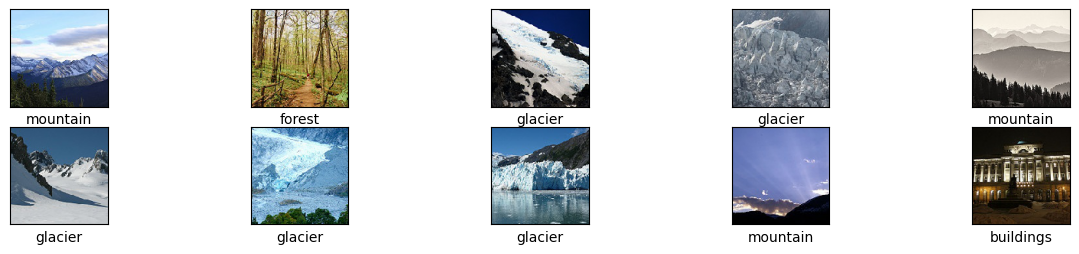

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(prediction_images)
predicted_labels = np.argmax(predicted_scores, axis=1)

random_indices = np.random.choice(len(prediction_images), size=10, replace=False)
print(len(prediction_images))

# Plot the prediction images along with their predicted labels
plt.figure(figsize=(15, 15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(10, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prediction_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    plt.xlabel(f"{predicted_label}")  # Plotting predicted label (true label)

# Save the plot as an image file
# plt.savefig("prediction_plot_cnn_model.png")
plt.show()